In [ ]:
pwd

In [ ]:
from datetime import datetime;now = datetime.now;t00 = now()
print(t00)

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

In [ ]:
%matplotlib inline

In [ ]:
#%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [ ]:
!nvidia-smi

In [ ]:
from importlib import reload

import helper_funcs;reload(helper_funcs);from helper_funcs import *

import make_models2;reload(make_models2);from make_models2 import *

# Make tqdm work for colab
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [ ]:
#%tensorflow_version 2.x
import tensorflow as tf
import timeit,pickle

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

In [ ]:
cd '/mmfs1/data/aglinska/BC-MRI-AE/Colab Notebooks'

In [ ]:
%matplotlib inline

import os
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from tqdm import tqdm

import pandas as pd
from sklearn.metrics import silhouette_score

#from mri_utils import get_MRI_CVAE_3D,get_MRI_CCVAE_3D

print(now()-t00)

In [ ]:
cd ../

In [ ]:
arr = np.load('./Data/ABIDE-Anat-64iso.npz')
ABIDE_data = arr['data']
ABIDE_subs = arr['subs']
nsubs = ABIDE_data.shape[0]
[arr.shape for arr in [ABIDE_subs,ABIDE_data]]

In [ ]:
aa = np.array([ABIDE_data[s,:,:,:].sum() for s in range(ABIDE_data.shape[0])])<5000
ABIDE_data = ABIDE_data[~aa,:,:,:]
ABIDE_subs = ABIDE_subs[~aa]
[arr.shape for arr in [ABIDE_subs,ABIDE_data]]

In [ ]:
# for i in range(982):
#     assert ABIDE_subs[i]==df['BIDS_ID'].values[i], '*youre* out of order'
#     np.save(file=os.path.join('./Assets/mats',ABIDE_subs[i]+'.npy'),arr=ABIDE_data[i,:,:,:])

In [ ]:
df = pd.read_csv('./CSVs/ABIDE-legend.csv',header=0)
df = df.iloc[np.array([df['BIDS_ID'].values[s] in ABIDE_subs for s in range(len(df))])]
df.reset_index(inplace=True)

assert len(df)==len(ABIDE_subs),'dif lenghts'
assert all([df['BIDS_ID'][s]==ABIDE_subs[s] for s in range(len(df))]),'mismatch between df and goodsubs'

df.head(5)

In [ ]:
#ABIDE_data = np.load('/mmfs1/data/aglinska/3d_grassy_mnist/fake_abide.npy')
TD_subs = ABIDE_data[np.array(df['Subject Type']=='CONTROL'),:,:,:]
DX_subs = ABIDE_data[np.array(df['Subject Type']=='PATIENT'),:,:,:]

print(TD_subs.shape)
print(DX_subs.shape)

In [ ]:
dxArr = np.ones(len(df))
dxArr[np.array(df['Subject Type']=='PATIENT')]=2

In [ ]:
# Get Scanner Types and Scanning Site
#df2 = pd.read_csv('/Users/aidasaglinskas/Desktop/BC-MRI-AE/CSVs/ABIDE_BIDS_PATHS.csv',index_col=0)
df2 = pd.read_csv('/mmfs1/data/aglinska/BC-MRI-AE/CSVs/ABIDE_BIDS_PATHS.csv',index_col=0)
df2.index=np.arange(len(df2))
df2 = df2.iloc[np.array([df2['subID'].values[s] in df['BIDS_ID'].values for s in np.arange(len(df2))])]
df2.index=np.arange(len(df2))
df2 = df2.sort_values('subID')
df2.index=np.arange(len(df2))
print(f'{len(df2)}/{len(df)}')
n = len(df2)
df2.head()

assert len(df2)==len(df), 'different lenghts of CSVs'
assert all(np.array([df2['subID'].values[s]==df['BIDS_ID'].values[s] for s in np.arange(len(df))])),'mismatch between CSV orders'

In [ ]:
df['ScanSite'] = [val.split('/')[6] for val in df2['sub_path'].values]
df['ScannerType'] = [val.split('/')[8] for val in df2['sub_path'].values]

In [ ]:
df['ScannerID'] = str_to_ordinal(df['ScannerType'].values)
df['ScanSiteID'] = str_to_ordinal(df['ScanSite'].values)

patients = df['DxGroup'].values==1
controls = df['DxGroup'].values==2

In [ ]:
print(df.shape)
print(ABIDE_data.shape)

In [ ]:
dataFnOut = '/mmfs1/data/aglinska/BC-MRI-AE/Data/ABIDE-Anat-64iso-S982.npz'
dfFnOut = '/mmfs1/data/aglinska/BC-MRI-AE/Data/ABIDE_legend.csv'
#np.savez_compressed(dataFnOut,data=ABIDE_data)
df.to_csv(dfFnOut)

In [1]:
!nvidia-smi

Sun Sep 19 09:59:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 450.51.05    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:18:00.0 Off |                    0 |
| N/A   39C    P0    71W / 300W |      3MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:3B:00.0 Off |                    0 |
| N/A   

In [2]:
from importlib import reload
import helper_funcs;reload(helper_funcs);from helper_funcs import *
import make_models2;reload(make_models2);from make_models2 import *
import numpy as np
import os
from tqdm import tqdm

In [3]:
train_vae = True

In [4]:
if train_vae:
    from scipy.spatial.distance import pdist
    from scipy.spatial.distance import squareform

def plot_recon_vae():
    plt.figure(figsize=(5,5));
    plt.subplot(2,2,1)
    plt.imshow(DX_batch[0,:,:,40]);plt.xticks([]);plt.yticks([]);plt.title('input');
    plt.subplot(2,2,2)
    plt.imshow(cvae.predict([DX_batch,TD_batch])[0][0,:,:,40,0]);plt.xticks([]);plt.yticks([]);plt.title('reconstruction');

    plt.subplot(2,2,3)
    plt.imshow(TD_batch[0,32,:,:]);plt.xticks([]);plt.yticks([]);
    plt.subplot(2,2,4)
    plt.imshow(cvae.predict([DX_batch,TD_batch])[1][0,32,:,:,0]);plt.xticks([]);plt.yticks([]);

In [5]:
import pickle
if train_vae:
#     latent_dim=32
#     batch_size=64
#     disentangle=False
#     gamma=1
    
    #encoder, decoder, vae = get_MRI_VAE_3D(input_shape=(64, 64, 64, 1), latent_dim=latent_dim, batch_size=batch_size, disentangle=disentangle, gamma=gamma)
    
    latent_dim = 32
    batch_size = 16
    disentangle = False
    gamma = 1

    encoder, decoder, vae = get_MRI_VAE_3D(input_shape=(64,64,64,1), 
                                            latent_dim=32, 
                                            batch_size = batch_size, 
                                            disentangle=True,
                                            gamma=100,
                                            kernel_size = 3,
                                            filters = 48,
                                            intermediate_dim = 128,
                                            nlayers = 2,
                                            bias=True)


    loss = list()
    print('ready')
    fn = '/mmfs1/data/aglinska/tf_outputs/VAE/20210919-1144'
    if os.path.exists(fn+'_loss.pickle'):
        print('loading weights')
        vae.load_weights(fn)
        loss = pickle.load(open(fn+'_loss.pickle','rb'))
    else:
        print('no weights found - initializing new')
        
    print(fn)

ready
no weights found - initializing new
/mmfs1/data/aglinska/tf_outputs/VAE/20210919-1144


In [6]:
indir = '/mmfs1/data/aglinska/BC-MRI-AE/Assets/mats'
files = [file for file in os.listdir(indir) if file.endswith('.npy')]
files.sort()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

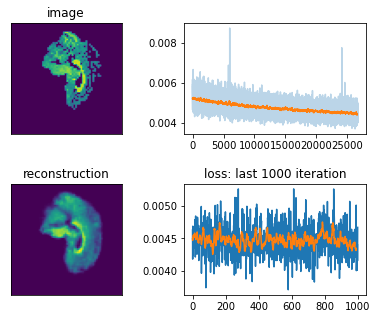

100%|██████████| 19999/19999 [3:33:29<00:00,  1.56it/s]


In [14]:
if train_vae:
    for i in tqdm(range(1,20000)):    
        #data_batch = ABIDE_data[np.random.randint(low=0,high=ABIDE_data.shape[0],size=batch_size),:,:,:]
        batch_idx = np.random.randint(low=0,high=len(files),size=batch_size)
        data_batch = np.array([np.load(os.path.join(indir,files[i])) for i in batch_idx])
        
        history = vae.train_on_batch(data_batch);
        mse = ((data_batch-vae.predict(data_batch)[:,:,:,:,0])**2).mean()
        loss.append(mse);
        
        if np.mod(i,25)==0:
            im1 = data_batch[0,32,:,:];
            im = vae.predict(data_batch)[0,32,:,:,0];
            plot_trainProgress(loss,im,im1);

        if np.mod(i,100)==0:
            pickle.dump(loss,open(fn+'_loss.pickle','wb'))
            vae.save_weights(fn)    
            
        
        if mse < .0035:
            break

In [ ]:
train_cvae=True

In [ ]:
items = get_weights(fdir=None)

In [ ]:
if train_cvae:
    latent_dim = 16
    batch_size = 32
    #batch_size = 64
    beta = 1;gamma = 100
    disentangle = True
    cvae, z_encoder, s_encoder, cvae_decoder = get_MRI_CCVAE_3D(latent_dim=latent_dim,beta=beta, disentangle=disentangle, gamma=gamma, bias=True, batch_size = batch_size)
    loss = list()    
    
    fdir = '/mmfs1/data/aglinska/tf_outputs/CVAE/'
    #fn = f'{now().strftime("%b%d_%H%M")}_D{latent_dim}B{beta}G{gamma}_D{disentangle}'
    fn = 'Feb04_0524_D16B1G100_DTrue'
    
    fn = os.path.join(fdir,fn)
    
    loss = pickle.load(open(fn+'_loss.pickle','rb'))
    cvae.load_weights(fn)

In [ ]:
fn

In [ ]:
# Initial Check
import helper_funcs;reload(helper_funcs);from helper_funcs import *
DX_batch = DX_subs[np.random.randint(low=0,high=DX_subs.shape[0],size=batch_size),:,:,:];
TD_batch = TD_subs[np.random.randint(low=0,high=TD_subs.shape[0],size=batch_size),:,:,:];

if len(loss)==0:
    loss.append(np.nan)
    im,im1,ss = cvae_query(ABIDE_data,s_encoder,z_encoder,cvae_decoder);
    plot_trainProgress(loss,im,im1);
    loss = list()
else:
    im,im1,ss = cvae_query(ABIDE_data,s_encoder,z_encoder,cvae_decoder);
    plot_trainProgress(loss,im,im1);

In [ ]:
import helper_funcs;reload(helper_funcs);from helper_funcs import *

if train_cvase:
    for i in tqdm(range(1,int(1e6))):

        #asd_idx,td_idx = get_batch_idx(df,batch_size = batch_size)
        #DX_batch = np.take(ABIDE_data, indices=asd_idx, axis=0)
        #TD_batch = np.take(ABIDE_data, indices=td_idx, axis=0)
        DX_batch = DX_subs[np.random.randint(low=0,high=DX_subs.shape[0],size=batch_size),:,:,:];
        TD_batch = TD_subs[np.random.randint(low=0,high=TD_subs.shape[0],size=batch_size),:,:,:];
        #print(TD_batch.shape)
        hist = cvae.train_on_batch([DX_batch,TD_batch]); # Proper 
        #hist = cvae.train_on_batch([TD_batch,DX_batch]); # Flipped

        assert not np.isnan(hist),'loss is NaN - you f**cked up'

        im,im1,ss = net_query();

        loss.append(hist);

        if np.mod(i,100)==0:
            plot_trainProgress(loss,im,im1);
            pickle.dump(loss,open(fn+'_loss.pickle','wb'))
            plot_four(DX_batch, TD_batch, z_encoder, s_encoder,cvae_decoder,cvae,idx=0)
            plot_four(DX_batch, TD_batch, z_encoder, s_encoder,cvae_decoder,cvae,idx=1)
            bg_space,sl_space = get_spaces(ABIDE_data, z_encoder, s_encoder, w=2)
            cscatter([bg_space,sl_space],c=df['DxGroup'].values)

            plt.figure(figsize=(5,5))
            plot_sweep(ABIDE_data, z_encoder, s_encoder,cvae_decoder, wspace='z', l=5)
            plt.show()

            plt.figure(figsize=(5,5))
            plot_sweep(ABIDE_data, z_encoder, s_encoder,cvae_decoder,wspace='s', l=5)
            plt.show()

            plot_cvae_silhouettes(ABIDE_data,z_encoder,s_encoder,patients,keys=None,l=8)

            plot_cvae_dif_mat(ABIDE_data,z_encoder,s_encoder,patients)
            plot_cvae_dif_mat(ABIDE_data,z_encoder,s_encoder,controls,keys = ['AgeAtScan','ScannerID','ScanSiteID','FIQ'])

        if np.mod(i,101)==0:
            cvae.save_weights(fn)